In [1]:
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az

import matplotlib as mpl
import matplotlib.pyplot as plt

from pytensor.tensor.math import gammaln, log
from lifelines import KaplanMeierFitter

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
ALPHA = 0.11 #Significance level for the prediction intervals

---

In [3]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Prognosis for women with breast cancer.dat", sep="\s+")

In [4]:
DatOriginal["stain"] = pd.get_dummies(DatOriginal["stain"], drop_first=True, dtype=int)

In [5]:
DatOriginal.head()

,stain,time,status
0,0,23,1
1,0,47,1
2,0,69,1
3,0,70,0
4,0,71,0


---

Weibull baseline functions

In [6]:
# Baseline Weibull log-hazard function
def WeibullLogHazard(t, alpha, beta):
    return -alpha*np.log(beta) + np.log(alpha) + (alpha-1)*np.log(t)

# Baseline Weibull hazard function
def WeibullHazard(t, alpha, beta):
    return np.exp(WeibullLogHazard(t, alpha, beta))

# Baseline cumulative hazard function
def WeibullCumulativeHazard(t, alpha, beta):
    return (t/beta)**alpha

Conditional functions, given the frailty

In [7]:
# Conditional survivor function, given the frailty
def ConditionalSurvivor(t, frailty, alpha, beta):
    return np.exp(-frailty * WeibullCumulativeHazard(t, alpha, beta))

Unconditional hazard and survivor functions

In [8]:
# Unconditional hazard function
def UnconditionalHazard(t, theta, alpha, beta):
    return WeibullHazard(t, alpha, beta) / (1 + 1/theta * WeibullCumulativeHazard(t, alpha, beta))

# Unconditional survivor function
def UnconditionalSurvivor(t, theta, alpha, beta):
    return (1 + 1/theta * WeibullCumulativeHazard(t, alpha, beta))**(-theta)

Posterior expected value of the frailty

In [9]:
def ExpectedFrailty(t, event, theta, alpha, beta):
    return (theta + event) / (theta + WeibullCumulativeHazard(t, alpha, beta))

Quantile survival time

In [10]:
def QuantileSurvival(p, theta, alpha, beta):
    return beta * (theta * (1-p)**(-1/theta)-1)**(1/alpha)

Hazard ratio

In [11]:
def HazardRatio(t, theta, alpha, beta0, beta1):
    num = WeibullHazard(t, alpha, beta1) * (1+1/theta * WeibullCumulativeHazard(t, alpha, beta0))
    den = WeibullHazard(t, alpha, beta0) * (1+1/theta * WeibullCumulativeHazard(t, alpha, beta1))
    return num / den

Log-likelihood

In [12]:
def LogLikelihood(t, event, theta, alpha, beta):
    return theta*log(theta) - gammaln(theta) + gammaln(theta+event) + event*WeibullLogHazard(t, alpha, beta) - (theta+event)*log(theta + WeibullCumulativeHazard(t, alpha, beta))

---

In [13]:
y = DatOriginal["time"].values
ev = DatOriginal["status"].values

with pm.Model() as WeibullFrailtyRegression:
    # Frailty
    Theta = pm.Exponential("Theta", 1)

    # Regression
    Zeta = pm.Normal("Zeta", mu=0, sigma=10, shape=2)

    # Weibull parameters
    Alpha = pm.HalfNormal("Alpha", sigma=10)
    Beta = pm.Deterministic("Beta", np.exp(Zeta))

    # Time quantile
    MedianTime = pm.Deterministic("MedianTime", QuantileSurvival(0.5, Theta, Alpha, Beta))

    # Log-likelihood
    pm.Potential(
        "Loglikelihood", LogLikelihood(y, ev, Theta, Alpha, Beta[DatOriginal["stain"]])
    )

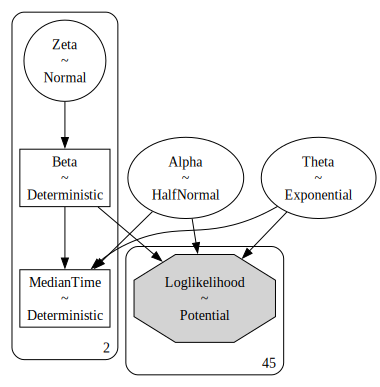

In [14]:
pm.model_to_graphviz(WeibullFrailtyRegression)

In [15]:
with WeibullFrailtyRegression:
    TraceWeibull = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Theta, Zeta, Alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 249 seconds.


In [16]:
az.summary(
    TraceWeibull,
    var_names=["Theta", "Alpha", "Zeta", "MedianTime"],
    kind="stats",
    stat_focus="median",
    hdi_prob=1-ALPHA
)

,median,mad,eti_5.5%,eti_94.5%
Theta,0.346,0.170,0.104,1.361
Alpha,1.732,0.440,1.023,3.525
Zeta[0],4.971,0.428,3.887,5.998
Zeta[1],3.807,0.356,2.904,4.570
MedianTime[0],215.371,74.189,98.732,619.014
MedianTime[1],65.029,15.092,39.251,144.722


Estimate the mean frailty value for each observation

In [17]:
Frailties = []

for index, d in DatOriginal.iterrows():
    Frailties.append(np.mean(
        ExpectedFrailty(
            d["time"],
            d["status"],
            TraceWeibull.posterior["Theta"],
            TraceWeibull.posterior["Alpha"],
            TraceWeibull.posterior["Beta"][:,:,d["stain"]]
        )
    ).values.reshape(1)[0])

DatOriginal.loc[:,"Frailty"] = Frailties

---

Plot the survivor functions and compare them with the KM estimator

In [18]:
DatOriginalNegative = DatOriginal[DatOriginal['stain']==0]
DatOriginalPositive = DatOriginal[DatOriginal['stain']==1]

In [19]:
t_vect = np.linspace(0, 250)

In [20]:
#Unconditional survivor function
for t in t_vect:
    if t==t_vect[0]:
        Survivor_0 = az.summary(
            UnconditionalSurvivor(
                t,
                TraceWeibull.posterior["Theta"],
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"][:,:,0]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]

        Survivor_1 = az.summary(
            UnconditionalSurvivor(
                t,
                TraceWeibull.posterior["Theta"],
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"][:,:,1]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
    else:
        Survivor_0 = pd.concat([
            Survivor_0,
            az.summary(
                UnconditionalSurvivor(
                    t,
                    TraceWeibull.posterior["Theta"],
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,0]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])

        Survivor_1 = pd.concat([
            Survivor_1,
            az.summary(
                UnconditionalSurvivor(
                    t,
                    TraceWeibull.posterior["Theta"],
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,1]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])

Survivor_0['time'] = t_vect
Survivor_1['time'] = t_vect

C:\Users\Dmitri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Dmitri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


C:\Users\Dmitri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Dmitri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Dmitri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Dmitri\AppData\Local\Packages\PythonSoftwar

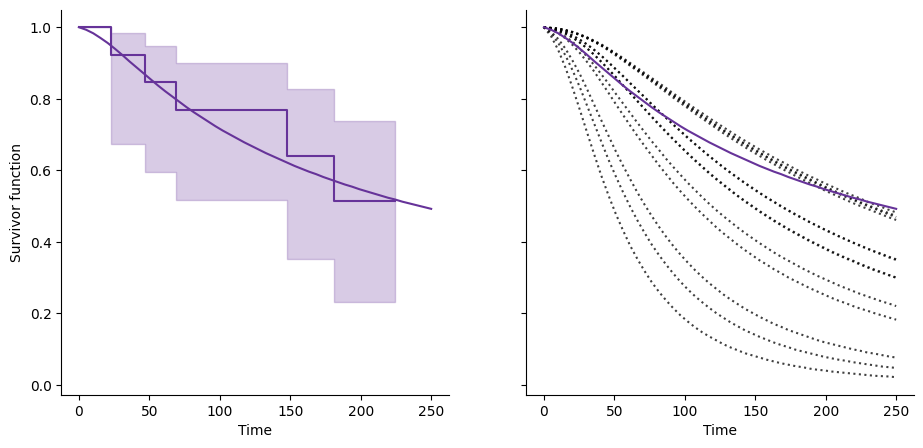

In [21]:
f, ax = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)

# Plot the conditional survivor functions and the unconditional survivor function
for f in DatOriginalNegative["Frailty"]:
    for t in t_vect:
        if t==t_vect[0]:
            CondSurvivor = az.summary(
                ConditionalSurvivor(
                    t,
                    f,
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,0]
                ), hdi_prob=1-ALPHA
            )[["mean"]]
        else:
            CondSurvivor = pd.concat([
                CondSurvivor,
                az.summary(
                    ConditionalSurvivor(
                        t,
                        f,
                        TraceWeibull.posterior["Alpha"],
                        TraceWeibull.posterior["Beta"][:,:,0]
                    ), hdi_prob=1-ALPHA
                )[["mean"]]
            ])

    _ = ax[1].plot(t_vect, CondSurvivor["mean"], color="k", alpha=0.75, linestyle=":")

ax[1].plot(Survivor_0['time'], Survivor_0['mean'], color="rebeccapurple")

ax[1].set_xlabel("Time")
ax[1].spines[['right', 'top']].set_visible(False)

# Plot the unconditional survivor function and the Kaplan-Meier estimator
ax[0].plot(Survivor_0['time'], Survivor_0['mean'], color="rebeccapurple")

kmf = KaplanMeierFitter(alpha=ALPHA)
kmf.fit(DatOriginalNegative['time'], event_observed=DatOriginalNegative['status'])
kmf.plot_survival_function(ax=ax[0], color="rebeccapurple")

ax[0].get_legend().remove()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Survivor function")
ax[0].spines[['right', 'top']].set_visible(False)

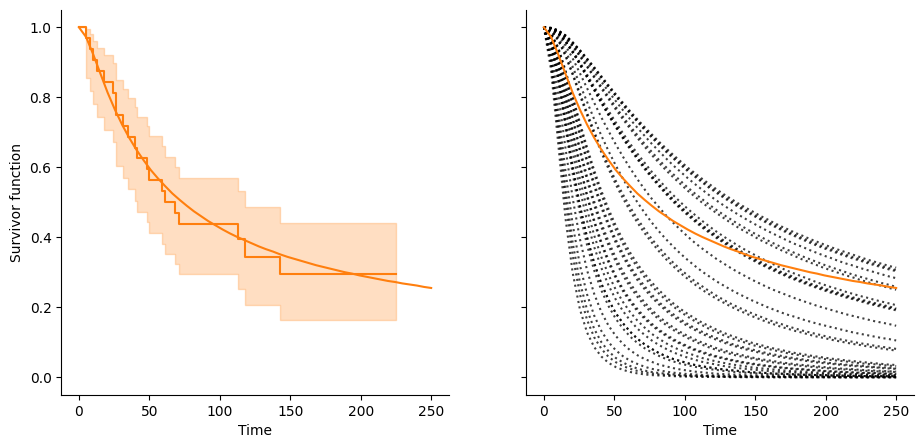

In [22]:
f, ax = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)

# Plot the conditional survivor functions and the unconditional survivor function
for f in DatOriginalPositive["Frailty"]:
    for t in t_vect:
        if t==t_vect[0]:
            CondSurvivor = az.summary(
                ConditionalSurvivor(
                    t,
                    f,
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,1]
                ), hdi_prob=1-ALPHA
            )[["mean"]]
        else:
            CondSurvivor = pd.concat([
                CondSurvivor,
                az.summary(
                    ConditionalSurvivor(
                        t,
                        f,
                        TraceWeibull.posterior["Alpha"],
                        TraceWeibull.posterior["Beta"][:,:,1]
                    ), hdi_prob=1-ALPHA
                )[["mean"]]
            ])

    _ = ax[1].plot(t_vect, CondSurvivor["mean"], color="k", alpha=0.75, linestyle=":")

ax[1].plot(Survivor_1['time'], Survivor_1['mean'], color=mpl.colormaps['tab10'].colors[1])

ax[1].set_xlabel("Time")
ax[1].spines[['right', 'top']].set_visible(False)

# Plot the unconditional survivor function and the Kaplan-Meier estimator
ax[0].plot(Survivor_1['time'], Survivor_1['mean'], color=mpl.colormaps['tab10'].colors[1])

kmf = KaplanMeierFitter(alpha=ALPHA)
kmf.fit(DatOriginalPositive['time'], event_observed=DatOriginalPositive['status'])
kmf.plot_survival_function(ax=ax[0], color=mpl.colormaps['tab10'].colors[1])

ax[0].get_legend().remove()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Survivor function")
ax[0].spines[['right', 'top']].set_visible(False)

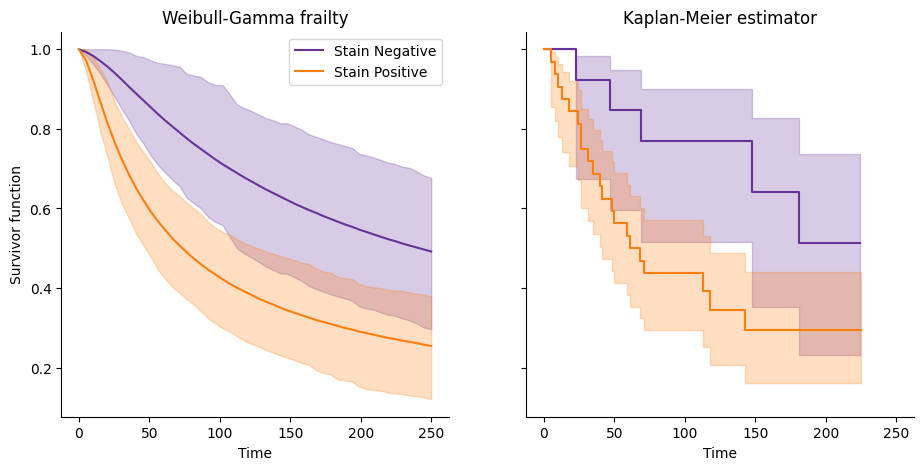

In [23]:
f, ax = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)

# Plot our Weibull model
ax[0].plot(
    Survivor_0["time"],
    Survivor_0["mean"],
    label="Stain Negative",
    color="rebeccapurple"
)

ax[0].fill_between(
    Survivor_0["time"],
    Survivor_0["hdi_"+str((ALPHA/2)*100)+"%"],
    Survivor_0["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color="rebeccapurple"
)

ax[0].plot(
    Survivor_1["time"],
    Survivor_1["mean"],
    label="Stain Positive",
    color=mpl.colormaps['tab10'].colors[1]
)

ax[0].fill_between(
    Survivor_1["time"],
    Survivor_1["hdi_"+str((ALPHA/2)*100)+"%"],
    Survivor_1["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color=mpl.colormaps['tab10'].colors[1]
)

ax[0].legend()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Survivor function")
ax[0].set_title("Weibull-Gamma frailty")
ax[0].spines[['right', 'top']].set_visible(False)

# Plot the Kaplan-Meier estimators
kmf = KaplanMeierFitter(alpha=ALPHA)
kmf.fit(DatOriginalNegative['time'], event_observed=DatOriginalNegative['status'])
kmf.plot_survival_function(ax=ax[1], color='rebeccapurple')

kmf.fit(DatOriginalPositive['time'], event_observed=DatOriginalPositive['status'])
kmf.plot_survival_function(ax=ax[1])

ax[1].get_legend().remove()
ax[1].set_xlabel("Time")
ax[1].set_title("Kaplan-Meier estimator")
ax[1].spines[['right', 'top']].set_visible(False)

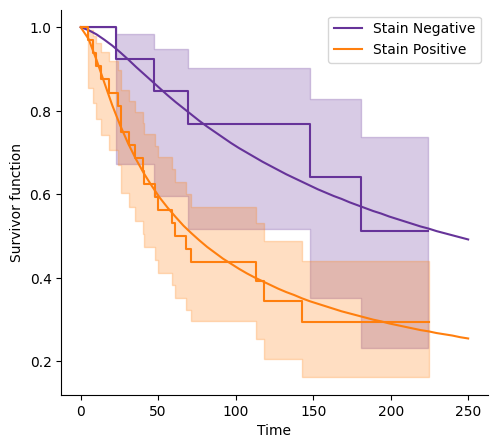

In [24]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

# Plot our Weibull model
ax.plot(
    Survivor_0["time"],
    Survivor_0["mean"],
    label="Stain Negative",
    color="rebeccapurple"
)

ax.plot(
    Survivor_1["time"],
    Survivor_1["mean"],
    label="Stain Positive",
    color=mpl.colormaps['tab10'].colors[1]
)

# Plot the Kaplan-Meier estimators
kmf = KaplanMeierFitter(alpha=ALPHA)
kmf.fit(DatOriginalNegative['time'], event_observed=DatOriginalNegative['status'])
kmf.plot_survival_function(ax=ax, color='rebeccapurple', label="")

kmf.fit(DatOriginalPositive['time'], event_observed=DatOriginalPositive['status'])
kmf.plot_survival_function(ax=ax, label="")

ax.get_legend().remove()
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Survivor function")
#ax.set_title("Weibull proportional hazards")
ax.spines[['right', 'top']].set_visible(False)


Plot the hazard functions

In [25]:
#Unconditional hazard functions
for t in t_vect:
    if t==t_vect[0]:
        Hazard_0 = az.summary(
            UnconditionalHazard(
                t,
                TraceWeibull.posterior["Theta"],
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"][:,:,0]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]

        Hazard_1 = az.summary(
            UnconditionalHazard(
                t,
                TraceWeibull.posterior["Theta"],
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"][:,:,1]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
    else:
        Hazard_0 = pd.concat([
            Hazard_0,
            az.summary(
                UnconditionalHazard(
                    t,
                    TraceWeibull.posterior["Theta"],
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,0]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])

        Hazard_1 = pd.concat([
            Hazard_1,
            az.summary(
                UnconditionalHazard(
                    t,
                    TraceWeibull.posterior["Theta"],
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,1]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])

Hazard_0['time'] = t_vect
Hazard_1['time'] = t_vect

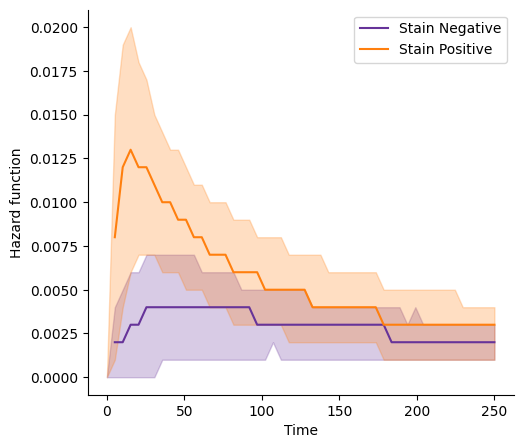

In [26]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

ax.plot(
    Hazard_0["time"],
    Hazard_0["mean"],
    label="Stain Negative",
    color="rebeccapurple"
)

ax.fill_between(
    Hazard_0["time"],
    Hazard_0["hdi_"+str((ALPHA/2)*100)+"%"],
    Hazard_0["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color="rebeccapurple"
)

ax.plot(
    Hazard_1["time"],
    Hazard_1["mean"],
    label="Stain Positive",
    color=mpl.colormaps['tab10'].colors[1]
)

ax.fill_between(
    Hazard_1["time"],
    Hazard_1["hdi_"+str((ALPHA/2)*100)+"%"],
    Hazard_1["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color=mpl.colormaps['tab10'].colors[1]
)

ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Hazard function")
ax.spines[['right', 'top']].set_visible(False)

Calculate hazard ratio

In [27]:
for t in t_vect:
    if t==t_vect[0]:
        HazardRatioTable = az.summary(
            HazardRatio(
                t,
                TraceWeibull.posterior["Theta"],
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"][:,:,0],
                TraceWeibull.posterior["Beta"][:,:,1]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
    else:
        HazardRatioTable = pd.concat([
            HazardRatioTable,
            az.summary(
                HazardRatio(
                    t,
                    TraceWeibull.posterior["Theta"],
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,0],
                    TraceWeibull.posterior["Beta"][:,:,1]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])

HazardRatioTable['time'] = t_vect
HazardRatioTable = HazardRatioTable.reset_index(drop=True)

arviz - WARNING - Array contains NaN-value.


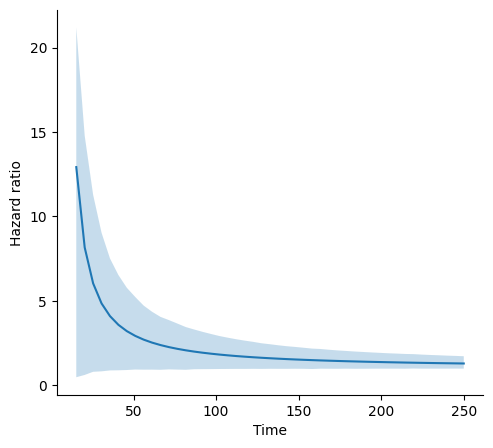

In [28]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

ax.plot(
    HazardRatioTable[3:]["time"],
    HazardRatioTable[3:]["mean"],
)

ax.fill_between(
    HazardRatioTable[3:]["time"],
    HazardRatioTable[3:]["hdi_"+str((ALPHA/2)*100)+"%"],
    HazardRatioTable[3:]["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25
)

ax.set_xlabel("Time")
ax.set_ylabel("Hazard ratio")
ax.spines[['right', 'top']].set_visible(False)


Estimate Median Survival Times

(0.0, 250.0)

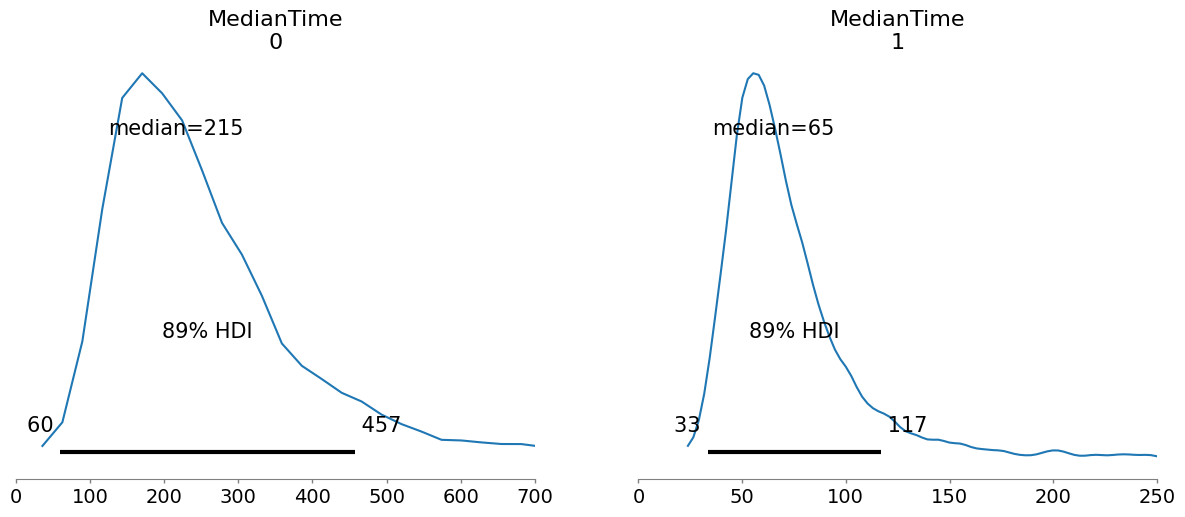

In [29]:
ax = az.plot_posterior(TraceWeibull, var_names=['MedianTime'], hdi_prob=1-ALPHA, point_estimate="median")

ax[0].set_xlim(0,700)
ax[1].set_xlim(0,250)

Text(0.5, 1.0, 'Median Survival Time')

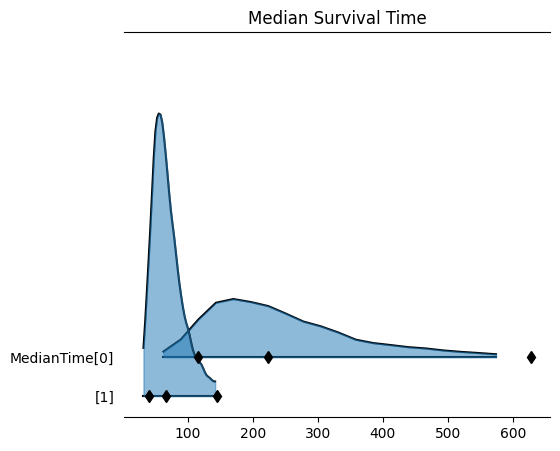

In [30]:
ax = az.plot_forest(
    TraceWeibull,
    kind='ridgeplot',
    var_names=['MedianTime'],
    combined=True,
    ridgeplot_quantiles=[ALPHA/2, 0.5, 1-ALPHA/2],
    ridgeplot_alpha=0.5,
    ridgeplot_overlap=6,
    figsize=(5.5, 5)
)

ax[0].set_title('Median Survival Time')

In [31]:
if False:
    MedianTime_1 = Survivor_1[Survivor_1["mean"]<0.5]["time"].values[0]
    LowMedianTime_1 = Survivor_1[Survivor_1["hdi_"+str((ALPHA/2)*100)+"%"]<0.5]["time"].values[0]
    UppMedianTime_1 = Survivor_1[Survivor_1["hdi_"+str((1-ALPHA/2)*100)+"%"]<0.5]["time"].values[0]

    LowMedianTime_1, MedianTime_1, UppMedianTime_1